In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [ ]:
y_var = pd.read_csv("drive/My Drive/Capstone Shared Docs/result/y_vars.csv")
score_tfidf = pd.read_csv("/content/drive/MyDrive/Capstone Shared Docs/strategy score/tf_idf_2011.csv")
score_word2vec = pd.read_csv("/content/drive/MyDrive/Capstone Shared Docs/strategy score/word2_vec_2011.csv")
score_BERT = pd.read_csv("/content/drive/MyDrive/Capstone Shared Docs/strategy score/BERT_2011.csv")

In [ ]:
y_var.head()

,portfoliocompanyid,dealcounts,dealsizeusdmn,seed_founding,firstrounds_founding,has_ipo,ipo_value,exit_value,exit_value_partiallyexited
0,26178,8,351.22,0.0,80.0,1.0,74.52,1674.52,74.52
1,26580,16,812.00,0.0,292.0,1.0,292.10,491.95,491.95
2,26635,8,710.00,0.0,710.0,1.0,151.30,151.30,151.30
3,26957,1,18.00,0.0,0.0,0.0,0.00,0.00,0.00
4,28167,1,0.00,0.0,0.0,0.0,0.00,0.00,0.00


In [ ]:
score = score_tfidf.copy()
score = score.rename(columns = {'Strat_score':'tfidf_score'}) 
score['word2vec_score'] = score_word2vec['Strat_score']
score['BERT_score'] = score_BERT['Strat_score']

In [ ]:
score.head(3)

,text,comp_type,text_cleaned,text_cleaned_with_sw,compid,language,Rela_language,text_len,words_len,website,name,info,Dict_similarity,tfidf_score,word2vec_score,BERT_score
0,Skip to main content area One Click: Safety - ...,S,skip main content area one click safety con...,skip to main content area one click safety ...,98564,en,True,8784,1186,www.stearclear.com,STEARCLEAR,"Founded in 2011 and is based in Paramus, New J...","{3051: 0.23346260078568049, 126701: 0.16235377...",0.840762,0.030242,0.318908
1,Home For Providers For Patients See WellFX Dem...,S,home providers patients see wellfx demo news p...,home for providers for patients see wellfx dem...,93680,en,True,8059,1037,www.well-fx.com,WellFX LLC,"Founded in 2011 and based in California US, We...","{639: 0.0716486793250373, 1638: 0.065549748351...",0.935614,0.033190,0.332222
2,How It Works For A Good Cause Log In Join Now ...,S,works good cause log join barkbox com make bes...,how it works for a good cause log in join now ...,106048,en,True,26178,3425,www.barkbox.com,"BarkBox, Inc.","Founded in 2011 and based in New York, US, Bar...","{1307: 0.24877625116625046, 110537: 0.23897494...",0.771925,0.009504,0.356085


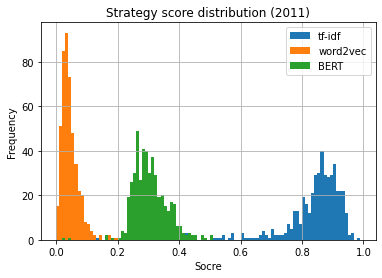

In [ ]:
score.tfidf_score.hist(bins=np.arange(0,1,0.01).tolist(), label = 'tf-idf')
score.word2vec_score.hist(bins=np.arange(0,1,0.01).tolist(),label = 'word2vec')
score.BERT_score.hist(bins=np.arange(0,1,0.01).tolist(),label = 'BERT')
plt.legend()
plt.title('Strategy score distribution (2011)')
plt.xlabel('Socre')
plt.ylabel('Frequency');

the word2vec need to be adjusted, given that most of companies are 'similar'.

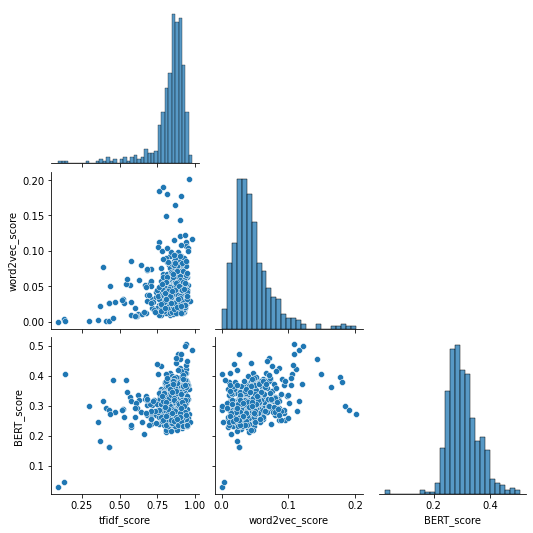

In [ ]:
subdf = score[['tfidf_score','word2vec_score','BERT_score']]
sns.pairplot(subdf, corner=True);

tf-idf and word2vec are related with each other to some degree

## Build Linear regression model

In [ ]:
# set index
y_var = y_var.set_index('portfoliocompanyid')
score = score.set_index('compid')

In [ ]:
print(y_var.shape)
print(score.shape)

(13704, 8)
(470, 15)


In [ ]:
df = pd.concat([y_var,score],axis=1,join='inner')

In [ ]:
df.head()

,dealcounts,dealsizeusdmn,seed_founding,firstrounds_founding,has_ipo,ipo_value,exit_value,exit_value_partiallyexited,text,comp_type,text_cleaned,text_cleaned_with_sw,language,Rela_language,text_len,words_len,website,name,info,Dict_similarity,tfidf_score,word2vec_score,BERT_score
72006,14,111.40,0.00,83.20,0.0,0.0,0.0,0.0,Email a Sales Engineer a Question Please corre...,S,email sales engineer question please correct f...,email a sales engineer a question please corre...,en,True,497668,128953,www.appneta.com,"AppNeta, Inc.","Founded in 2011 and based in Massachusetts, Ap...","{1640: 0.7137819907606033, 7431: 0.70959319808...",0.457320,0.005415,0.384161
72459,10,240.00,0.00,206.00,0.0,0.0,0.0,0.0,Sign Into Yahoo! New User? Sign Up Voice Home ...,S,sign yahoo new user sign voice home help n...,sign into yahoo new user sign up voice home ...,en,True,9644,1268,www.dialpad.com,"Dialpad, Inc.","Founded in 2011 and based in California, US, D...","{5598: 0.8341507689962296, 77176: 0.6544544604...",0.388242,0.076961,0.315790
72495,3,11.50,0.85,5.25,0.0,0.0,0.0,0.0,PunchTab Developers How PunchTab works Log in ...,S,punchtab developers punchtab works log invalid...,punchtab developers how punchtab works log in ...,en,True,24006,3225,www.punchtab.com,"PunchTab, Inc.","Founded in 2011, PunchTab is a loyalty platfor...","{95019: 0.11501415250206415, 1690: 0.083924614...",0.912619,0.026383,0.233239
72620,2,3.60,0.60,3.60,0.0,0.0,0.0,0.0,BestVendor Play Video What is BestVendor? Sign...,S,bestvendor play video bestvendor sign bestven...,bestvendor play video what is bestvendor sign...,en,True,46939,5897,www.bestvendor.com,BestVendor,"Founded in 2011 and is based in Washington, Di...","{137208: 0.2555456063124094, 110537: 0.2519659...",0.763173,0.009705,0.262664
72976,2,3.41,0.00,2.50,0.0,0.0,0.0,0.0,mission apps team jobs contact press Tweet Str...,S,mission apps team jobs contact press tweet str...,mission apps team jobs contact press tweet str...,en,True,438,61,www.azumio.com,Azumio,"Founded in 2011 and based in Palo Alto, Califo...","{6643: 0.192270023203575, 4551: 0.176114989381...",0.857275,0.094309,0.381392


In [ ]:
scores = ['tfidf_score','word2vec_score','BERT_score']
dep_vars = ['seed_founding','firstrounds_founding','ipo_value']

def LinearReg(df,scores,dep_vars):
  fig, ax = plt.subplots(len(scores),len(dep_vars),figsize=(14,14))

  i = 0
  j = 0
  for score in scores:
    for dep_var in dep_vars:
      X = np.asarray(df[score]).reshape((-1,1))
      y = np.asarray(df[dep_var])
      reg = LinearRegression().fit(X,y)
      y_hat = reg.predict(X)

      print('score:',score, ' dependent variable: ',dep_var)
      print('R2 score:',reg.score(X,y))
      print('Coefficents (slope)',reg.coef_)
      print('\n')

      ax[i,j].scatter(X,y, alpha = 0.5)
      ax[i,j].set_xlabel(score)
      ax[i,j].set_ylabel(dep_var)
      ax[i,j].plot(X,y_hat,color = 'red')

      j = j+1
    j = 0
    i = i + 1

score: tfidf_score  dependent variable:  seed_founding
R2 score: 0.0009583955764522757
Coefficents (slope) [0.81307481]


score: tfidf_score  dependent variable:  firstrounds_founding
R2 score: 0.0008141092542085504
Coefficents (slope) [-23.8733754]


score: tfidf_score  dependent variable:  ipo_value
R2 score: 0.0006947857943983005
Coefficents (slope) [37.36138993]


score: word2vec_score  dependent variable:  seed_founding
R2 score: 0.007544471233922546
Coefficents (slope) [9.25528763]


score: word2vec_score  dependent variable:  firstrounds_founding
R2 score: 0.00010598151132257261
Coefficents (slope) [-34.94660137]


score: word2vec_score  dependent variable:  ipo_value
R2 score: 0.0029629712952984337
Coefficents (slope) [313.02476051]


score: BERT_score  dependent variable:  seed_founding
R2 score: 0.0033068533181418447
Coefficents (slope) [3.18992661]


score: BERT_score  dependent variable:  firstrounds_founding
R2 score: 0.0005162803484222156
Coefficents (slope) [-40.15414644

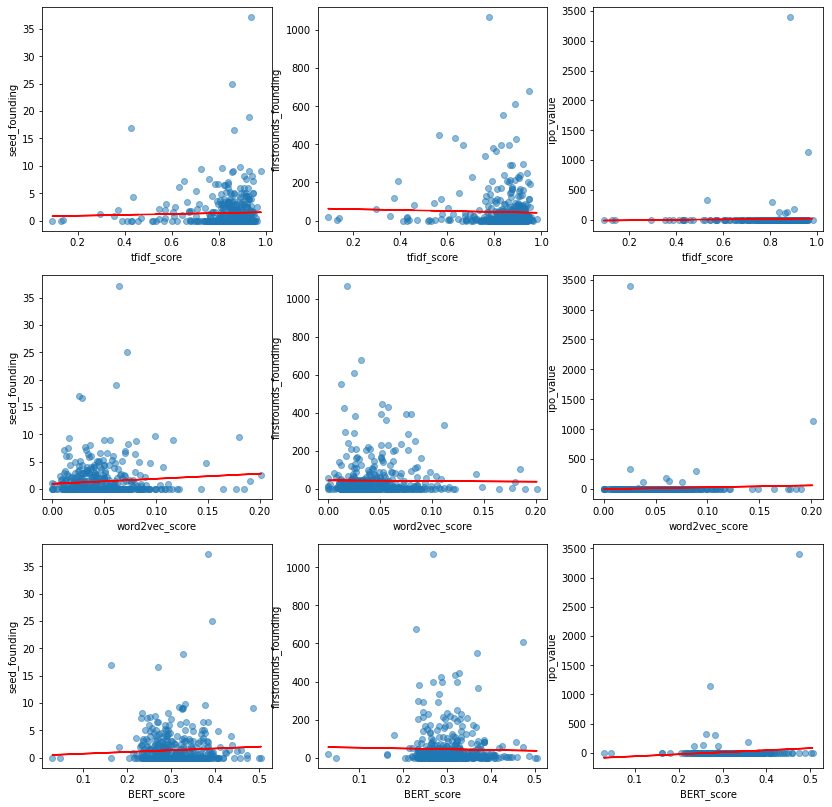

In [ ]:
LinearReg(df,scores,dep_vars)

## Our strategy scores DO NOT perform well but DO show something

- tf-idf show the trend that: with a higher similarity score, we will see a higher seed or first rounds foundings. 

- coefficients tell more: 0.81307481 in the seed founding and tf-idf shows the positive relationship


## To explore

- to further improve our result, to normalize the data would be good, say log.

- we may care more about the has_IPO than the IPO value, which could reduce the variance

- add fixed-effect analysis (year, location, industry) would be helpful

- try to analyze other kinds of exits and see the difference